In [1]:
import numpy as np
import h5py
import torch
import torch.optim as optim
from tqdm import tqdm
import copy
import pandas as pd
import sys
import random
import os
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt



sys.path.append('../')
from utils.misc import args_parser, average_weights
from utils.misc import get_data, process_isolated
from utils.models import LSTM
from utils.fed_update import LocalUpdate, test_inference
from sklearn import metrics

In [5]:
close_size = 3
period_size = 3
out_dim = 1
test_days = 7
val_days = 0
seed = 1
bs = 100
frac = 0.1
fedsgd = 1
local_bs = 20
epochs = 10

In [6]:
def get_data(args):
    path = os.getcwd()
    f = h5py.File(path + '/dataset/' + args, 'r')

    idx = f['idx'][()]
    cell = f['cell'][()]
    lng = f['lng'][()]
    lat = f['lat'][()]
    data = f['call'][()][:, cell - 1]

    
    
    df = pd.DataFrame(data, index=pd.to_datetime(idx.ravel(), unit='s'), columns=cell)
    df.fillna(0, inplace=True)
    print(df)

    random.seed(1500)
    cell_pool = cell
    selected_cells = sorted(random.sample(list(cell_pool), bs))
    selected_cells_idx = np.where(np.isin(list(cell), selected_cells))
    cell_lng = lng[selected_cells_idx]
    cell_lat = lat[selected_cells_idx]
    # print('Selected cells:', selected_cells)

    df_cells = df[selected_cells]
    # print(df_cells.head())

    train_data = df_cells.iloc[:-test_days * 24]

    mean = train_data.mean()
    std = train_data.std()

    normalized_df = (df_cells - mean) / std

    return normalized_df, df_cells, selected_cells, mean, std, cell_lng, cell_lat
def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]

def time_slide_df2(df, window_size, forecast_size):
    df_ = df.copy()
    x_dict = {}
    y_dict = {}
    date_dict = {}
    date = 'date_time'
    
    # Drop the date column from the target list to avoid duplication
    target_cols = [col for col in df_.columns if col != date]
    
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        for col in target_cols:
            x = df_.loc[idx:idx + window_size - 1, col].values.reshape(window_size, 1)
            y = df_.loc[idx + window_size:idx + window_size + forecast_size - 1, col].values
            date_ = df_.loc[idx + window_size:idx + window_size + forecast_size - 1, date].values
            
            if col not in x_dict:
                x_dict[col] = []
            if col not in y_dict:
                y_dict[col] = []
            if col not in date_dict:
                date_dict[col] = []
            
            x_dict[col].append(x)
            y_dict[col].append(y)
            date_dict[col].append(date_)
    
    for col in target_cols:
        x_dict[col] = np.array(x_dict[col], dtype='float32')
        y_dict[col] = np.array(y_dict[col], dtype='float32')
        date_dict[col] = np.array(date_dict[col])
    
    return x_dict, y_dict, date_dict

def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

def restart_index(df):
    df_reset_index = df.reset_index(drop=True)
    df_reset_index.index = df_reset_index.index
    return df_reset_index

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    class LTSF_Linear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_Linear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        if self.individual:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        return x
    
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

IndentationError: expected an indented block (174826465.py, line 115)

In [7]:
df,ori_df,df_s,_,_,_,_ = get_data("milano.h5")

AttributeError: 'str' object has no attribute 'file'

In [48]:
df_reset = df.reset_index()
df_reset = df_reset.rename(columns={'index': 'date_time'})

train_df = df_reset.iloc[:-24*7].copy()
test_df = df_reset.iloc[-24*7:].copy()
test_df = restart_index(test_df)

In [49]:
targets=1012

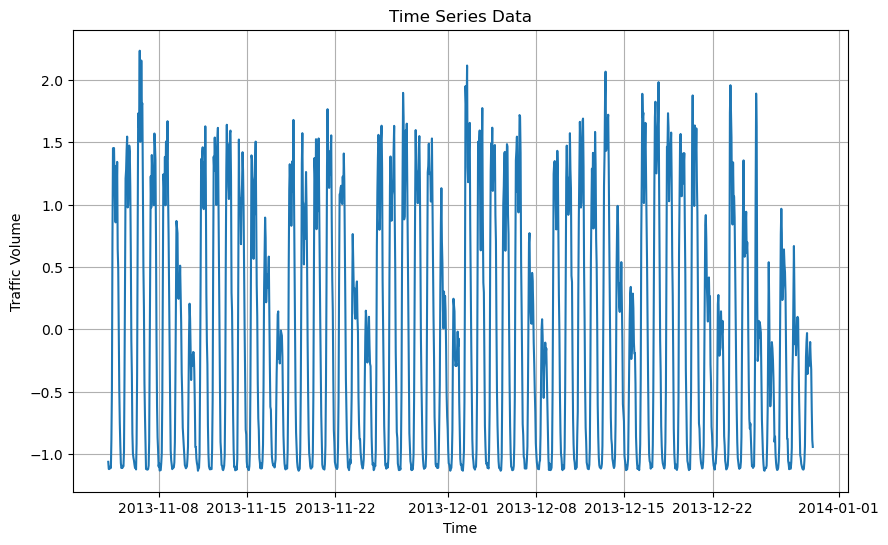

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(df_reset['date_time'], df_reset[targets])
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.title('Time Series Data')
plt.grid(True)
plt.show()

In [60]:
### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forcast_size= 3
batch_size = 20
targets = 1012
date = 'date_time'

#train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'date_time', targets)
#def time_slide_df(df, window_size, forcast_size, date, target):
    
train_x, train_y, train_date = time_slide_df(train_df, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df, window_size, forcast_size, date, targets)


In [61]:
train_ds = Data(train_x[:1000], train_y[:1000])
valid_ds = Data(train_x[1000:], train_y[1000:])
test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)

valid_dl = DataLoader(valid_ds, batch_size = train_x[1000:].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)

In [62]:

### DLinear 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 200
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  2%|█▎                                                                | 4/200 [00:00<00:10, 18.67it/s]

valid_loss=0.178, test_los0.156, Model Save
epoch = 1, train_loss : 0.357, valid_loss : 0.178, test_loss : 0.156
valid_loss=0.126, test_los0.132, Model Save
epoch = 2, train_loss : 0.166, valid_loss : 0.126, test_loss : 0.132
valid_loss=0.097, test_los0.116, Model Save
epoch = 3, train_loss : 0.130, valid_loss : 0.097, test_loss : 0.116
valid_loss=0.082, test_los0.106, Model Save
epoch = 4, train_loss : 0.112, valid_loss : 0.082, test_loss : 0.106


  4%|██▋                                                               | 8/200 [00:00<00:09, 19.34it/s]

valid_loss=0.079, test_los0.102, Model Save
epoch = 5, train_loss : 0.101, valid_loss : 0.079, test_loss : 0.102
epoch = 6, train_loss : 0.093, valid_loss : 0.081, test_loss : 0.106
valid_loss=0.071, test_los0.088, Model Save
epoch = 7, train_loss : 0.088, valid_loss : 0.071, test_loss : 0.088
valid_loss=0.066, test_los0.090, Model Save
epoch = 8, train_loss : 0.083, valid_loss : 0.066, test_loss : 0.090


  6%|███▉                                                             | 12/200 [00:00<00:09, 19.59it/s]

valid_loss=0.065, test_los0.076, Model Save
epoch = 9, train_loss : 0.079, valid_loss : 0.065, test_loss : 0.076
valid_loss=0.059, test_los0.078, Model Save
epoch = 10, train_loss : 0.078, valid_loss : 0.059, test_loss : 0.078
epoch = 11, train_loss : 0.076, valid_loss : 0.067, test_loss : 0.089
epoch = 12, train_loss : 0.074, valid_loss : 0.063, test_loss : 0.082


  8%|█████▏                                                           | 16/200 [00:00<00:09, 19.74it/s]

valid_loss=0.057, test_los0.077, Model Save
epoch = 13, train_loss : 0.072, valid_loss : 0.057, test_loss : 0.077
epoch = 14, train_loss : 0.071, valid_loss : 0.062, test_loss : 0.069
epoch = 15, train_loss : 0.070, valid_loss : 0.059, test_loss : 0.070
epoch = 16, train_loss : 0.069, valid_loss : 0.062, test_loss : 0.074
epoch = 17, train_loss : 0.068, valid_loss : 0.059, test_loss : 0.063


 10%|██████▌                                                          | 20/200 [00:01<00:09, 19.80it/s]

epoch = 18, train_loss : 0.067, valid_loss : 0.060, test_loss : 0.077
epoch = 19, train_loss : 0.067, valid_loss : 0.058, test_loss : 0.074
valid_loss=0.056, test_los0.078, Model Save
epoch = 20, train_loss : 0.067, valid_loss : 0.056, test_loss : 0.078
epoch = 21, train_loss : 0.066, valid_loss : 0.058, test_loss : 0.066


 12%|███████▊                                                         | 24/200 [00:01<00:08, 19.79it/s]

valid_loss=0.055, test_los0.066, Model Save
epoch = 22, train_loss : 0.065, valid_loss : 0.055, test_loss : 0.066
epoch = 23, train_loss : 0.066, valid_loss : 0.056, test_loss : 0.065
valid_loss=0.054, test_los0.070, Model Save
epoch = 24, train_loss : 0.066, valid_loss : 0.054, test_loss : 0.070
epoch = 25, train_loss : 0.066, valid_loss : 0.056, test_loss : 0.069


 14%|█████████                                                        | 28/200 [00:01<00:08, 19.87it/s]

epoch = 26, train_loss : 0.064, valid_loss : 0.062, test_loss : 0.079
epoch = 27, train_loss : 0.065, valid_loss : 0.057, test_loss : 0.065
epoch = 28, train_loss : 0.064, valid_loss : 0.057, test_loss : 0.064
epoch = 29, train_loss : 0.064, valid_loss : 0.058, test_loss : 0.061
valid_loss=0.053, test_los0.065, Model Save


 17%|███████████                                                      | 34/200 [00:01<00:08, 19.91it/s]

epoch = 30, train_loss : 0.064, valid_loss : 0.053, test_loss : 0.065
epoch = 31, train_loss : 0.063, valid_loss : 0.061, test_loss : 0.077
epoch = 32, train_loss : 0.063, valid_loss : 0.057, test_loss : 0.078
epoch = 33, train_loss : 0.063, valid_loss : 0.054, test_loss : 0.058
epoch = 34, train_loss : 0.063, valid_loss : 0.060, test_loss : 0.065


 19%|████████████▎                                                    | 38/200 [00:01<00:08, 19.89it/s]

epoch = 35, train_loss : 0.063, valid_loss : 0.055, test_loss : 0.065
valid_loss=0.053, test_los0.061, Model Save
epoch = 36, train_loss : 0.063, valid_loss : 0.053, test_loss : 0.061
epoch = 37, train_loss : 0.063, valid_loss : 0.055, test_loss : 0.068
epoch = 38, train_loss : 0.063, valid_loss : 0.054, test_loss : 0.066


 21%|█████████████▋                                                   | 42/200 [00:02<00:07, 19.90it/s]

epoch = 39, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.063
epoch = 40, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.067
epoch = 41, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.067
epoch = 42, train_loss : 0.063, valid_loss : 0.058, test_loss : 0.062
epoch = 43, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.066


 24%|███████████████▌                                                 | 48/200 [00:02<00:07, 19.91it/s]

epoch = 44, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.074
epoch = 45, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.063
epoch = 46, train_loss : 0.062, valid_loss : 0.060, test_loss : 0.063
epoch = 47, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.074
epoch = 48, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.069


 26%|████████████████▉                                                | 52/200 [00:02<00:07, 19.91it/s]

epoch = 49, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.057
epoch = 50, train_loss : 0.062, valid_loss : 0.054, test_loss : 0.065
epoch = 51, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.070
epoch = 52, train_loss : 0.063, valid_loss : 0.055, test_loss : 0.073
epoch = 53, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.065


 28%|██████████████████▏                                              | 56/200 [00:02<00:07, 19.89it/s]

epoch = 54, train_loss : 0.062, valid_loss : 0.066, test_loss : 0.065
epoch = 55, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.068
epoch = 56, train_loss : 0.061, valid_loss : 0.063, test_loss : 0.069
epoch = 57, train_loss : 0.062, valid_loss : 0.059, test_loss : 0.062
epoch = 58, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.058


 31%|████████████████████▏                                            | 62/200 [00:03<00:06, 19.85it/s]

epoch = 59, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.064
epoch = 60, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.069
epoch = 61, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.066
epoch = 62, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.065


 33%|█████████████████████▍                                           | 66/200 [00:03<00:06, 19.83it/s]

epoch = 63, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.066
epoch = 64, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.072
epoch = 65, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.076
epoch = 66, train_loss : 0.061, valid_loss : 0.065, test_loss : 0.072


 35%|██████████████████████▊                                          | 70/200 [00:03<00:06, 19.82it/s]

epoch = 67, train_loss : 0.063, valid_loss : 0.067, test_loss : 0.070
epoch = 68, train_loss : 0.063, valid_loss : 0.057, test_loss : 0.075
epoch = 69, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.065
epoch = 70, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.080


 37%|████████████████████████                                         | 74/200 [00:03<00:06, 19.83it/s]

epoch = 71, train_loss : 0.061, valid_loss : 0.063, test_loss : 0.077
epoch = 72, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.073
epoch = 73, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.072
epoch = 74, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.058


 39%|█████████████████████████▎                                       | 78/200 [00:03<00:06, 19.83it/s]

epoch = 75, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.065
epoch = 76, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.059
epoch = 77, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.064
epoch = 78, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.066


 41%|██████████████████████████▋                                      | 82/200 [00:04<00:05, 19.84it/s]

epoch = 79, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.068
epoch = 80, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.061
epoch = 81, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.077
epoch = 82, train_loss : 0.060, valid_loss : 0.062, test_loss : 0.076


 43%|███████████████████████████▉                                     | 86/200 [00:04<00:05, 19.85it/s]

epoch = 83, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.063
epoch = 84, train_loss : 0.061, valid_loss : 0.063, test_loss : 0.065
epoch = 85, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.065
epoch = 86, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.068


 45%|█████████████████████████████▎                                   | 90/200 [00:04<00:05, 19.84it/s]

epoch = 87, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.072
epoch = 88, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.062
epoch = 89, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.058
epoch = 90, train_loss : 0.062, valid_loss : 0.054, test_loss : 0.060


 47%|██████████████████████████████▌                                  | 94/200 [00:04<00:05, 19.86it/s]

epoch = 91, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.064
epoch = 92, train_loss : 0.060, valid_loss : 0.062, test_loss : 0.071
epoch = 93, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.066
epoch = 94, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.056


 49%|███████████████████████████████▊                                 | 98/200 [00:04<00:05, 19.88it/s]

epoch = 95, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.069
epoch = 96, train_loss : 0.061, valid_loss : 0.061, test_loss : 0.078
epoch = 97, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.067
epoch = 98, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.062
epoch = 99, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.059


 52%|█████████████████████████████████▎                              | 104/200 [00:05<00:04, 19.89it/s]

epoch = 100, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.073
epoch = 101, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.082
epoch = 102, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.061
epoch = 103, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.066
epoch = 104, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.075


 54%|██████████████████████████████████▌                             | 108/200 [00:05<00:04, 19.89it/s]

epoch = 105, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.065
epoch = 106, train_loss : 0.060, valid_loss : 0.067, test_loss : 0.082
epoch = 107, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.068
epoch = 108, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.070


 56%|███████████████████████████████████▊                            | 112/200 [00:05<00:04, 19.90it/s]

epoch = 109, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.075
epoch = 110, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.066
epoch = 111, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.057
epoch = 112, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.071
epoch = 113, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.067


 59%|█████████████████████████████████████▊                          | 118/200 [00:05<00:04, 19.92it/s]

epoch = 114, train_loss : 0.060, valid_loss : 0.063, test_loss : 0.078
epoch = 115, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.055
epoch = 116, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.067
epoch = 117, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.066
epoch = 118, train_loss : 0.061, valid_loss : 0.070, test_loss : 0.082


 61%|███████████████████████████████████████                         | 122/200 [00:06<00:03, 19.92it/s]

epoch = 119, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.060
epoch = 120, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.067
epoch = 121, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.067
epoch = 122, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.071
epoch = 123, train_loss : 0.061, valid_loss : 0.062, test_loss : 0.069


 64%|████████████████████████████████████████▉                       | 128/200 [00:06<00:03, 19.92it/s]

epoch = 124, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.064
epoch = 125, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.061
epoch = 126, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.072
epoch = 127, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.063
epoch = 128, train_loss : 0.060, valid_loss : 0.065, test_loss : 0.079


 66%|██████████████████████████████████████████▏                     | 132/200 [00:06<00:03, 19.90it/s]

epoch = 129, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.069
epoch = 130, train_loss : 0.062, valid_loss : 0.061, test_loss : 0.063
epoch = 131, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.068
epoch = 132, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.065


 68%|███████████████████████████████████████████▌                    | 136/200 [00:06<00:03, 19.89it/s]

epoch = 133, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.063
epoch = 134, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.069
epoch = 135, train_loss : 0.061, valid_loss : 0.062, test_loss : 0.078
epoch = 136, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.069


 70%|████████████████████████████████████████████▊                   | 140/200 [00:07<00:03, 19.89it/s]

epoch = 137, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.063
epoch = 138, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.065
epoch = 139, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.079
epoch = 140, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.071


 72%|██████████████████████████████████████████████                  | 144/200 [00:07<00:02, 19.89it/s]

epoch = 141, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.078
epoch = 142, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.064
epoch = 143, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.061
epoch = 144, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.059
epoch = 145, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.072


 74%|███████████████████████████████████████████████▎                | 148/200 [00:07<00:02, 19.85it/s]

epoch = 146, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.069
epoch = 147, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.066
epoch = 148, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.063
epoch = 149, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.074


 76%|████████████████████████████████████████████████▋               | 152/200 [00:07<00:02, 19.85it/s]

epoch = 150, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.069
epoch = 151, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.060
epoch = 152, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.071
epoch = 153, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.082


 78%|█████████████████████████████████████████████████▉              | 156/200 [00:07<00:02, 19.85it/s]

epoch = 154, train_loss : 0.059, valid_loss : 0.053, test_loss : 0.058
epoch = 155, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.064
epoch = 156, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.063
epoch = 157, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.065


 80%|███████████████████████████████████████████████████▏            | 160/200 [00:08<00:02, 19.86it/s]

epoch = 158, train_loss : 0.059, valid_loss : 0.062, test_loss : 0.072
epoch = 159, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.068
epoch = 160, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.075
epoch = 161, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.067


 82%|████████████████████████████████████████████████████▍           | 164/200 [00:08<00:01, 19.86it/s]

epoch = 162, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.065
epoch = 163, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.059
epoch = 164, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.059
valid_loss=0.053, test_los0.057, Model Save
epoch = 165, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.057


 84%|█████████████████████████████████████████████████████▊          | 168/200 [00:08<00:01, 19.83it/s]

epoch = 166, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.066
epoch = 167, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.058
epoch = 168, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.067
epoch = 169, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.071


 86%|███████████████████████████████████████████████████████         | 172/200 [00:08<00:01, 19.84it/s]

epoch = 170, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.066
epoch = 171, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.064
epoch = 172, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.064
epoch = 173, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.069


 88%|████████████████████████████████████████████████████████▎       | 176/200 [00:08<00:01, 19.85it/s]

epoch = 174, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.068
epoch = 175, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.059
epoch = 176, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.078
epoch = 177, train_loss : 0.060, valid_loss : 0.063, test_loss : 0.067


 90%|█████████████████████████████████████████████████████████▌      | 180/200 [00:09<00:01, 19.85it/s]

epoch = 178, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.067
epoch = 179, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.077
epoch = 180, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.057
epoch = 181, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.069


 92%|██████████████████████████████████████████████████████████▉     | 184/200 [00:09<00:00, 19.84it/s]

epoch = 182, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.069
epoch = 183, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.058
epoch = 184, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.070
epoch = 185, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.058


 94%|████████████████████████████████████████████████████████████▏   | 188/200 [00:09<00:00, 19.85it/s]

epoch = 186, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.066
epoch = 187, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.064
epoch = 188, train_loss : 0.060, valid_loss : 0.060, test_loss : 0.073
epoch = 189, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.064


 96%|█████████████████████████████████████████████████████████████▍  | 192/200 [00:09<00:00, 19.85it/s]

epoch = 190, train_loss : 0.061, valid_loss : 0.064, test_loss : 0.072
epoch = 191, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.059
epoch = 192, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.064
epoch = 193, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.064


 98%|██████████████████████████████████████████████████████████████▋ | 196/200 [00:09<00:00, 19.85it/s]

epoch = 194, train_loss : 0.061, valid_loss : 0.064, test_loss : 0.079
epoch = 195, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.075
epoch = 196, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.060
epoch = 197, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.066


100%|████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.83it/s]

epoch = 198, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.059
epoch = 199, train_loss : 0.059, valid_loss : 0.055, test_loss : 0.066
epoch = 200, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.072


In [38]:
### Llinear모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 200
lr = 0.001
Linear_model = LTSF_Linear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Linear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    Linear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = Linear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    Linear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = Linear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = Linear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(Linear_model, 'Linear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        linear_best_epoch = epoch
        linear_best_train_loss = np.mean(loss_list)
        linear_best_valid_loss = np.mean(valid_loss.item())
        linear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  4%|██▉                                                               | 9/200 [00:00<00:04, 43.78it/s]

valid_loss=0.329, test_los0.444, Model Save
epoch = 1, train_loss : 0.646, valid_loss : 0.329, test_loss : 0.444
valid_loss=0.264, test_los0.411, Model Save
epoch = 2, train_loss : 0.306, valid_loss : 0.264, test_loss : 0.411
valid_loss=0.239, test_los0.396, Model Save
epoch = 3, train_loss : 0.257, valid_loss : 0.239, test_loss : 0.396
valid_loss=0.220, test_los0.385, Model Save
epoch = 4, train_loss : 0.229, valid_loss : 0.220, test_loss : 0.385
valid_loss=0.213, test_los0.379, Model Save
epoch = 5, train_loss : 0.209, valid_loss : 0.213, test_loss : 0.379
valid_loss=0.201, test_los0.370, Model Save
epoch = 6, train_loss : 0.196, valid_loss : 0.201, test_loss : 0.370
valid_loss=0.197, test_los0.363, Model Save
epoch = 7, train_loss : 0.190, valid_loss : 0.197, test_loss : 0.363
valid_loss=0.194, test_los0.361, Model Save
epoch = 8, train_loss : 0.181, valid_loss : 0.194, test_loss : 0.361
epoch = 9, train_loss : 0.178, valid_loss : 0.198, test_loss : 0.352
valid_loss=0.185, test_los0

 10%|██████▏                                                          | 19/200 [00:00<00:03, 46.56it/s]

valid_loss=0.184, test_los0.348, Model Save
epoch = 11, train_loss : 0.173, valid_loss : 0.184, test_loss : 0.348
epoch = 12, train_loss : 0.168, valid_loss : 0.188, test_loss : 0.343
valid_loss=0.178, test_los0.337, Model Save
epoch = 13, train_loss : 0.167, valid_loss : 0.178, test_loss : 0.337
valid_loss=0.176, test_los0.335, Model Save
epoch = 14, train_loss : 0.165, valid_loss : 0.176, test_loss : 0.335
epoch = 15, train_loss : 0.164, valid_loss : 0.180, test_loss : 0.331
epoch = 16, train_loss : 0.161, valid_loss : 0.181, test_loss : 0.331
valid_loss=0.170, test_los0.327, Model Save
epoch = 17, train_loss : 0.163, valid_loss : 0.170, test_loss : 0.327
valid_loss=0.169, test_los0.327, Model Save
epoch = 18, train_loss : 0.159, valid_loss : 0.169, test_loss : 0.327
epoch = 19, train_loss : 0.158, valid_loss : 0.179, test_loss : 0.327
valid_loss=0.168, test_los0.325, Model Save
epoch = 20, train_loss : 0.157, valid_loss : 0.168, test_loss : 0.325


 14%|█████████▍                                                       | 29/200 [00:00<00:03, 47.48it/s]

epoch = 21, train_loss : 0.156, valid_loss : 0.171, test_loss : 0.319
valid_loss=0.166, test_los0.316, Model Save
epoch = 22, train_loss : 0.154, valid_loss : 0.166, test_loss : 0.316
epoch = 23, train_loss : 0.155, valid_loss : 0.177, test_loss : 0.317
epoch = 24, train_loss : 0.153, valid_loss : 0.167, test_loss : 0.319
valid_loss=0.163, test_los0.313, Model Save
epoch = 25, train_loss : 0.153, valid_loss : 0.163, test_loss : 0.313
epoch = 26, train_loss : 0.150, valid_loss : 0.177, test_loss : 0.316
epoch = 27, train_loss : 0.151, valid_loss : 0.165, test_loss : 0.317
valid_loss=0.159, test_los0.313, Model Save
epoch = 28, train_loss : 0.150, valid_loss : 0.159, test_loss : 0.313
epoch = 29, train_loss : 0.151, valid_loss : 0.171, test_loss : 0.310
epoch = 30, train_loss : 0.149, valid_loss : 0.166, test_loss : 0.311


 20%|████████████▋                                                    | 39/200 [00:00<00:03, 48.29it/s]

epoch = 31, train_loss : 0.148, valid_loss : 0.166, test_loss : 0.313
epoch = 32, train_loss : 0.150, valid_loss : 0.166, test_loss : 0.309
epoch = 33, train_loss : 0.148, valid_loss : 0.163, test_loss : 0.309
epoch = 34, train_loss : 0.148, valid_loss : 0.171, test_loss : 0.309
epoch = 35, train_loss : 0.148, valid_loss : 0.171, test_loss : 0.312
epoch = 36, train_loss : 0.145, valid_loss : 0.167, test_loss : 0.310
epoch = 37, train_loss : 0.146, valid_loss : 0.164, test_loss : 0.303
epoch = 38, train_loss : 0.145, valid_loss : 0.166, test_loss : 0.306
epoch = 39, train_loss : 0.146, valid_loss : 0.165, test_loss : 0.308
epoch = 40, train_loss : 0.146, valid_loss : 0.165, test_loss : 0.309


 24%|███████████████▉                                                 | 49/200 [00:01<00:03, 48.58it/s]

epoch = 41, train_loss : 0.145, valid_loss : 0.160, test_loss : 0.307
epoch = 42, train_loss : 0.144, valid_loss : 0.160, test_loss : 0.305
epoch = 43, train_loss : 0.144, valid_loss : 0.163, test_loss : 0.305
valid_loss=0.158, test_los0.304, Model Save
epoch = 44, train_loss : 0.143, valid_loss : 0.158, test_loss : 0.304
epoch = 45, train_loss : 0.145, valid_loss : 0.167, test_loss : 0.305
epoch = 46, train_loss : 0.143, valid_loss : 0.171, test_loss : 0.304
valid_loss=0.157, test_los0.302, Model Save
epoch = 47, train_loss : 0.144, valid_loss : 0.157, test_loss : 0.302
epoch = 48, train_loss : 0.144, valid_loss : 0.164, test_loss : 0.307
epoch = 49, train_loss : 0.145, valid_loss : 0.166, test_loss : 0.307
epoch = 50, train_loss : 0.143, valid_loss : 0.159, test_loss : 0.307


 30%|███████████████████▏                                             | 59/200 [00:01<00:02, 48.81it/s]

epoch = 51, train_loss : 0.142, valid_loss : 0.166, test_loss : 0.302
epoch = 52, train_loss : 0.142, valid_loss : 0.163, test_loss : 0.305
epoch = 53, train_loss : 0.143, valid_loss : 0.161, test_loss : 0.299
epoch = 54, train_loss : 0.144, valid_loss : 0.169, test_loss : 0.303
epoch = 55, train_loss : 0.141, valid_loss : 0.168, test_loss : 0.305
epoch = 56, train_loss : 0.142, valid_loss : 0.167, test_loss : 0.301
epoch = 57, train_loss : 0.141, valid_loss : 0.168, test_loss : 0.304
epoch = 58, train_loss : 0.142, valid_loss : 0.162, test_loss : 0.303
epoch = 59, train_loss : 0.141, valid_loss : 0.168, test_loss : 0.305
epoch = 60, train_loss : 0.141, valid_loss : 0.164, test_loss : 0.303


 34%|██████████████████████▍                                          | 69/200 [00:01<00:02, 48.77it/s]

epoch = 61, train_loss : 0.142, valid_loss : 0.158, test_loss : 0.299
epoch = 62, train_loss : 0.139, valid_loss : 0.173, test_loss : 0.302
epoch = 63, train_loss : 0.141, valid_loss : 0.165, test_loss : 0.301
valid_loss=0.152, test_los0.295, Model Save
epoch = 64, train_loss : 0.141, valid_loss : 0.152, test_loss : 0.295
epoch = 65, train_loss : 0.141, valid_loss : 0.169, test_loss : 0.304
epoch = 66, train_loss : 0.140, valid_loss : 0.158, test_loss : 0.296
epoch = 67, train_loss : 0.140, valid_loss : 0.160, test_loss : 0.301
epoch = 68, train_loss : 0.139, valid_loss : 0.158, test_loss : 0.301
epoch = 69, train_loss : 0.139, valid_loss : 0.169, test_loss : 0.301
epoch = 70, train_loss : 0.140, valid_loss : 0.161, test_loss : 0.296


 40%|█████████████████████████▋                                       | 79/200 [00:01<00:02, 48.82it/s]

epoch = 71, train_loss : 0.138, valid_loss : 0.161, test_loss : 0.301
valid_loss=0.150, test_los0.294, Model Save
epoch = 72, train_loss : 0.140, valid_loss : 0.150, test_loss : 0.294
epoch = 73, train_loss : 0.139, valid_loss : 0.160, test_loss : 0.299
epoch = 74, train_loss : 0.139, valid_loss : 0.161, test_loss : 0.298
epoch = 75, train_loss : 0.139, valid_loss : 0.165, test_loss : 0.299
epoch = 76, train_loss : 0.139, valid_loss : 0.156, test_loss : 0.298
epoch = 77, train_loss : 0.141, valid_loss : 0.159, test_loss : 0.294
epoch = 78, train_loss : 0.138, valid_loss : 0.159, test_loss : 0.299
epoch = 79, train_loss : 0.139, valid_loss : 0.159, test_loss : 0.297
epoch = 80, train_loss : 0.141, valid_loss : 0.157, test_loss : 0.296


 44%|████████████████████████████▉                                    | 89/200 [00:01<00:02, 48.97it/s]

epoch = 81, train_loss : 0.139, valid_loss : 0.159, test_loss : 0.299
epoch = 82, train_loss : 0.138, valid_loss : 0.152, test_loss : 0.298
epoch = 83, train_loss : 0.138, valid_loss : 0.162, test_loss : 0.295
epoch = 84, train_loss : 0.139, valid_loss : 0.162, test_loss : 0.296
epoch = 85, train_loss : 0.138, valid_loss : 0.158, test_loss : 0.294
epoch = 86, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.293
epoch = 87, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.294
epoch = 88, train_loss : 0.140, valid_loss : 0.156, test_loss : 0.296
epoch = 89, train_loss : 0.138, valid_loss : 0.164, test_loss : 0.301
epoch = 90, train_loss : 0.138, valid_loss : 0.171, test_loss : 0.301


 50%|████████████████████████████████▏                                | 99/200 [00:02<00:02, 48.91it/s]

epoch = 91, train_loss : 0.138, valid_loss : 0.169, test_loss : 0.298
epoch = 92, train_loss : 0.139, valid_loss : 0.173, test_loss : 0.299
epoch = 93, train_loss : 0.137, valid_loss : 0.171, test_loss : 0.297
epoch = 94, train_loss : 0.139, valid_loss : 0.169, test_loss : 0.297
epoch = 95, train_loss : 0.138, valid_loss : 0.153, test_loss : 0.288
epoch = 96, train_loss : 0.138, valid_loss : 0.152, test_loss : 0.293
epoch = 97, train_loss : 0.137, valid_loss : 0.152, test_loss : 0.294
epoch = 98, train_loss : 0.139, valid_loss : 0.160, test_loss : 0.295
epoch = 99, train_loss : 0.137, valid_loss : 0.162, test_loss : 0.295
epoch = 100, train_loss : 0.139, valid_loss : 0.166, test_loss : 0.295


 55%|██████████████████████████████████▉                             | 109/200 [00:02<00:01, 49.11it/s]

epoch = 101, train_loss : 0.139, valid_loss : 0.165, test_loss : 0.297
epoch = 102, train_loss : 0.140, valid_loss : 0.161, test_loss : 0.296
epoch = 103, train_loss : 0.137, valid_loss : 0.171, test_loss : 0.304
epoch = 104, train_loss : 0.138, valid_loss : 0.151, test_loss : 0.294
epoch = 105, train_loss : 0.138, valid_loss : 0.159, test_loss : 0.296
epoch = 106, train_loss : 0.137, valid_loss : 0.152, test_loss : 0.298
epoch = 107, train_loss : 0.138, valid_loss : 0.156, test_loss : 0.300
epoch = 108, train_loss : 0.137, valid_loss : 0.153, test_loss : 0.294
epoch = 109, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.296
epoch = 110, train_loss : 0.137, valid_loss : 0.172, test_loss : 0.298


 60%|██████████████████████████████████████                          | 119/200 [00:02<00:01, 49.06it/s]

epoch = 111, train_loss : 0.137, valid_loss : 0.157, test_loss : 0.300
epoch = 112, train_loss : 0.139, valid_loss : 0.153, test_loss : 0.294
epoch = 113, train_loss : 0.137, valid_loss : 0.157, test_loss : 0.291
epoch = 114, train_loss : 0.138, valid_loss : 0.158, test_loss : 0.297
epoch = 115, train_loss : 0.138, valid_loss : 0.155, test_loss : 0.294
epoch = 116, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.293
epoch = 117, train_loss : 0.139, valid_loss : 0.166, test_loss : 0.303
epoch = 118, train_loss : 0.138, valid_loss : 0.167, test_loss : 0.304
epoch = 119, train_loss : 0.138, valid_loss : 0.153, test_loss : 0.293
epoch = 120, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.296


 64%|█████████████████████████████████████████▎                      | 129/200 [00:02<00:01, 48.85it/s]

epoch = 121, train_loss : 0.137, valid_loss : 0.163, test_loss : 0.297
epoch = 122, train_loss : 0.138, valid_loss : 0.159, test_loss : 0.293
epoch = 123, train_loss : 0.137, valid_loss : 0.156, test_loss : 0.290
epoch = 124, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.295
epoch = 125, train_loss : 0.137, valid_loss : 0.164, test_loss : 0.297
epoch = 126, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.297
epoch = 127, train_loss : 0.139, valid_loss : 0.153, test_loss : 0.294
epoch = 128, train_loss : 0.138, valid_loss : 0.158, test_loss : 0.298
epoch = 129, train_loss : 0.136, valid_loss : 0.170, test_loss : 0.299
epoch = 130, train_loss : 0.136, valid_loss : 0.155, test_loss : 0.294


 70%|████████████████████████████████████████████▍                   | 139/200 [00:02<00:01, 48.74it/s]

epoch = 131, train_loss : 0.138, valid_loss : 0.155, test_loss : 0.291
epoch = 132, train_loss : 0.138, valid_loss : 0.162, test_loss : 0.301
epoch = 133, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.297
epoch = 134, train_loss : 0.136, valid_loss : 0.166, test_loss : 0.293
epoch = 135, train_loss : 0.136, valid_loss : 0.165, test_loss : 0.293
epoch = 136, train_loss : 0.138, valid_loss : 0.151, test_loss : 0.291
epoch = 137, train_loss : 0.134, valid_loss : 0.164, test_loss : 0.297
epoch = 138, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.291
epoch = 139, train_loss : 0.136, valid_loss : 0.161, test_loss : 0.293
epoch = 140, train_loss : 0.138, valid_loss : 0.162, test_loss : 0.293


 74%|███████████████████████████████████████████████▋                | 149/200 [00:03<00:01, 48.69it/s]

epoch = 141, train_loss : 0.136, valid_loss : 0.164, test_loss : 0.296
epoch = 142, train_loss : 0.136, valid_loss : 0.161, test_loss : 0.291
epoch = 143, train_loss : 0.137, valid_loss : 0.165, test_loss : 0.297
epoch = 144, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.297
epoch = 145, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.295
epoch = 146, train_loss : 0.136, valid_loss : 0.166, test_loss : 0.296
epoch = 147, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.294
valid_loss=0.148, test_los0.292, Model Save
epoch = 148, train_loss : 0.138, valid_loss : 0.148, test_loss : 0.292
epoch = 149, train_loss : 0.137, valid_loss : 0.153, test_loss : 0.294
epoch = 150, train_loss : 0.136, valid_loss : 0.158, test_loss : 0.297


 80%|██████████████████████████████████████████████████▉             | 159/200 [00:03<00:00, 48.63it/s]

epoch = 151, train_loss : 0.136, valid_loss : 0.159, test_loss : 0.290
epoch = 152, train_loss : 0.136, valid_loss : 0.169, test_loss : 0.295
epoch = 153, train_loss : 0.137, valid_loss : 0.157, test_loss : 0.291
epoch = 154, train_loss : 0.139, valid_loss : 0.163, test_loss : 0.298
epoch = 155, train_loss : 0.136, valid_loss : 0.162, test_loss : 0.295
epoch = 156, train_loss : 0.136, valid_loss : 0.156, test_loss : 0.294
epoch = 157, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.293
epoch = 158, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.293
epoch = 159, train_loss : 0.136, valid_loss : 0.171, test_loss : 0.297
epoch = 160, train_loss : 0.137, valid_loss : 0.169, test_loss : 0.293


 84%|██████████████████████████████████████████████████████          | 169/200 [00:03<00:00, 48.65it/s]

epoch = 161, train_loss : 0.137, valid_loss : 0.168, test_loss : 0.296
epoch = 162, train_loss : 0.138, valid_loss : 0.165, test_loss : 0.296
epoch = 163, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.294
epoch = 164, train_loss : 0.139, valid_loss : 0.169, test_loss : 0.298
epoch = 165, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.294
epoch = 166, train_loss : 0.135, valid_loss : 0.160, test_loss : 0.294
epoch = 167, train_loss : 0.137, valid_loss : 0.160, test_loss : 0.291
valid_loss=0.148, test_los0.291, Model Save
epoch = 168, train_loss : 0.137, valid_loss : 0.148, test_loss : 0.291
epoch = 169, train_loss : 0.137, valid_loss : 0.153, test_loss : 0.292
epoch = 170, train_loss : 0.136, valid_loss : 0.155, test_loss : 0.292


 90%|█████████████████████████████████████████████████████████▎      | 179/200 [00:03<00:00, 48.73it/s]

epoch = 171, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.292
epoch = 172, train_loss : 0.134, valid_loss : 0.153, test_loss : 0.293
epoch = 173, train_loss : 0.137, valid_loss : 0.155, test_loss : 0.293
epoch = 174, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.291
epoch = 175, train_loss : 0.137, valid_loss : 0.162, test_loss : 0.294
epoch = 176, train_loss : 0.136, valid_loss : 0.162, test_loss : 0.295
epoch = 177, train_loss : 0.136, valid_loss : 0.155, test_loss : 0.294
epoch = 178, train_loss : 0.138, valid_loss : 0.155, test_loss : 0.294
epoch = 179, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.292
epoch = 180, train_loss : 0.136, valid_loss : 0.158, test_loss : 0.296


 94%|████████████████████████████████████████████████████████████▍   | 189/200 [00:03<00:00, 48.65it/s]

epoch = 181, train_loss : 0.136, valid_loss : 0.159, test_loss : 0.296
epoch = 182, train_loss : 0.137, valid_loss : 0.172, test_loss : 0.294
epoch = 183, train_loss : 0.137, valid_loss : 0.162, test_loss : 0.296
epoch = 184, train_loss : 0.136, valid_loss : 0.159, test_loss : 0.292
epoch = 185, train_loss : 0.134, valid_loss : 0.160, test_loss : 0.289
epoch = 186, train_loss : 0.135, valid_loss : 0.154, test_loss : 0.292
epoch = 187, train_loss : 0.135, valid_loss : 0.162, test_loss : 0.292
valid_loss=0.147, test_los0.286, Model Save
epoch = 188, train_loss : 0.137, valid_loss : 0.147, test_loss : 0.286
epoch = 189, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.293
epoch = 190, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.293


100%|████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.41it/s]

epoch = 191, train_loss : 0.134, valid_loss : 0.157, test_loss : 0.297
epoch = 192, train_loss : 0.135, valid_loss : 0.163, test_loss : 0.290
epoch = 193, train_loss : 0.136, valid_loss : 0.156, test_loss : 0.295
epoch = 194, train_loss : 0.135, valid_loss : 0.163, test_loss : 0.297
epoch = 195, train_loss : 0.135, valid_loss : 0.156, test_loss : 0.292
epoch = 196, train_loss : 0.135, valid_loss : 0.157, test_loss : 0.293
epoch = 197, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.292
epoch = 198, train_loss : 0.137, valid_loss : 0.155, test_loss : 0.293
epoch = 199, train_loss : 0.135, valid_loss : 0.155, test_loss : 0.289
epoch = 200, train_loss : 0.137, valid_loss : 0.152, test_loss : 0.289


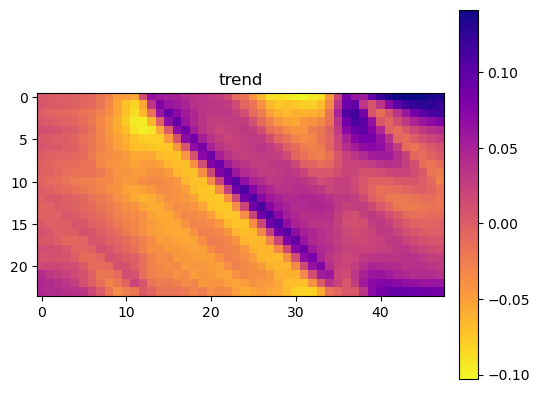

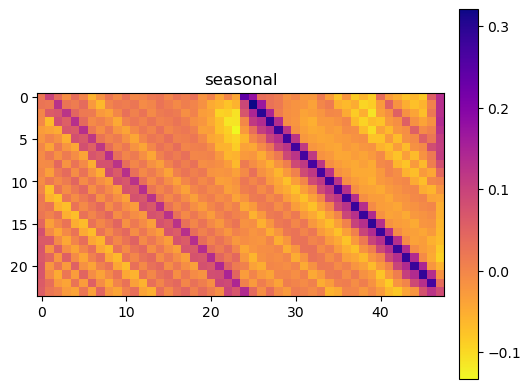

In [243]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

for name, w in weights_list.items():    
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()